This file has methods to visualize Enformer prediction simulations which are augmented with varying degrees of signal separating the donor-derived and recipient-derived fragments. It has methods to do the following
1. Generate simulated by randomly sampling between max and minimum values for each Enformer track
2. For some percentage of samples (s) replace value of some percentage of features (f) with a value slightly higher than the max for all donor-derived samples, and a value slightly lower than the minimum of the track for all recipient-derived samples.
3. Make a separate box plot for donor- and recipient-derived fragments of all features for varying ranges of 's'. The distribution should go higher for increasing 's' for donor-derived samples and the opposite should happen for recipient-derived samples.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random

import seaborn as sns

import sys 
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')

import importlib
import config
importlib.reload(config)

<module 'config' from '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/config.py'>

In [2]:
arguments = {}
arguments["trainingEnformerTracksAverageFile"] = config.filePaths.get("trainingEnformerTracksAverageFile")
arguments["validationEnformerTracksAverageFile"] = config.filePaths.get("validationEnformerTracksAverageFile")

training_enformer_track_ranges = pd.read_csv(arguments["trainingEnformerTracksAverageFile"], sep='\t')
validation_enformer_track_ranges = pd.read_csv(arguments["validationEnformerTracksAverageFile"], sep='\t')

In [3]:
"""
This function first generated random values of simulated Enformer tracks based on the track's minimum and maximum
Then, signal is artifically addded into the data for a specific number of features or samples, as configured. 
"""
def getSimulatedData(track_ranges, num_samples, percent_features, percent_samples):
    min_all_tracks = track_ranges["min"]
    max_all_tracks = track_ranges["max"]
    num_tracks = len(min_all_tracks)
    print(f"Num tracks : {num_tracks} and number of samples: {num_samples}")

    simulated_samples = np.empty((num_samples, num_tracks))

    #Function to generate random data (after getting the range for each feature)
    for i in range(0, num_tracks):
        simulated_track = np.random.uniform(min_all_tracks[i], max_all_tracks[i], num_samples)
        simulated_samples[:, i] = simulated_track

    zeros = np.zeros(math.floor(num_samples/2))
    ones = np.ones(num_samples - len(zeros))
    labels = np.concatenate((zeros, ones), axis = 0)
    np.random.shuffle(labels)

    if(percent_features > 0 and percent_samples > 0):
        #Randomly pick some samples and some features from the simulated random data and add some signal. 
        num_track_with_signal = math.floor((percent_features * num_tracks)/100)
        num_samples_with_signal = math.floor((percent_samples * num_samples)/100)

        track_indices = random.sample(range(0, num_tracks), num_track_with_signal) #Randomly choose some tracks to add signal to
        track_indices = [68]
        sample_indices = random.sample(range(0, num_samples), num_samples_with_signal) #Randomly choose some samples to add signal to

        print(f"Num augmented tracks: {len(track_indices)} and num aug samples : {len(sample_indices)}")

        #For each track, replace some sample with augumented signal - if the sample has a positive label, then make the value slighty higher than the highest value
        #If the sample is negative, the augumented value will be 1 less than the lowest value for the track. 
        pos_indices = np.where(labels == 1)
        pos_indices_to_replace = np.intersect1d(sample_indices, pos_indices)

        neg_indices = np.where(labels == 0)
        neg_indices_to_replace = np.intersect1d(sample_indices, neg_indices)
        
        for track_index in track_indices:
            #Replace positive samples for this track
            max_track = max_all_tracks[track_index]
            replacement_pos_val = random.uniform(max_track, 1.001*max_track)
            simulated_samples[pos_indices_to_replace, track_index] = replacement_pos_val

            #Replace negative samples for this track
            min_track = min_all_tracks[track_index]         
            replacement_neg_val = random.uniform(0.9*min_track, min_track) #Replace with a value slightly lower than the lowest value of that track
            simulated_samples[neg_indices_to_replace, track_index] = replacement_neg_val

    return simulated_samples, labels

In [4]:
sample_percents = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
track_percent = 100
positives_map = {}
negatives_map = {}
map_keys = ["0", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100"]

for i, sample_percent in enumerate(sample_percents):
    print("------------------------------------------------------------------------------------------------------")
    print(f"Sample percent is : {sample_percent}")
    simulated_samples, labels = getSimulatedData(training_enformer_track_ranges, num_samples=10000, percent_features=10, percent_samples=sample_percent)
    pos_indices = np.array((labels == 1))
    neg_indices = np.array((labels == 0))
    one_track_simulated_samples = simulated_samples[:, 68].ravel()
    positives_map[map_keys[i]] = one_track_simulated_samples[pos_indices]
    negatives_map[map_keys[i]] = one_track_simulated_samples[neg_indices]
    print("------------------------------------------------------------------------------------------------------")


pos_df = pd.DataFrame(data = positives_map)
neg_df = pd.DataFrame(data = negatives_map)

# Convert the dfs into long format for getting into the format that box plot needs. 
long_pos_df = pd.melt(pos_df, value_vars=map_keys, var_name="%_samples_augmented", value_name="Enformer track values")
long_neg_df = pd.melt(neg_df, value_vars=map_keys, var_name="%_samples_augmented", value_name="Enformer track values")

------------------------------------------------------------------------------------------------------
Sample percent is : 0
Num tracks : 5313 and number of samples: 10000
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Sample percent is : 10
Num tracks : 5313 and number of samples: 10000
Num augmented tracks: 1 and num aug samples : 1000
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Sample percent is : 20
Num tracks : 5313 and number of samples: 10000
Num augmented tracks: 1 and num aug samples : 2000
------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

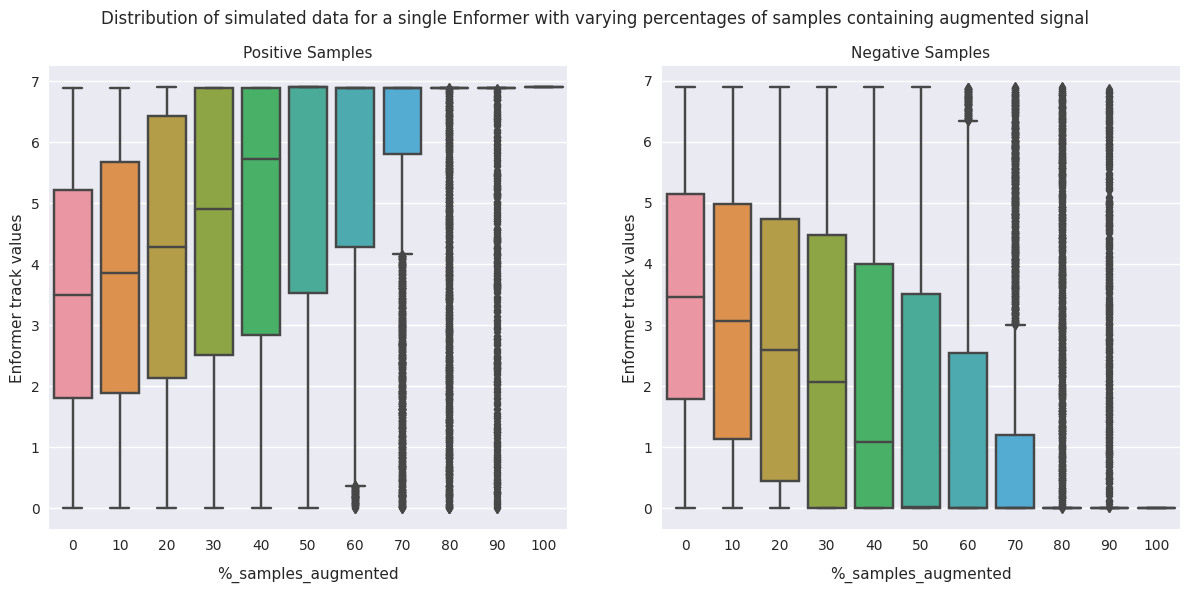

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

s1 = sns.boxplot(data = long_pos_df,x = "%_samples_augmented", y = "Enformer track values", ax = ax1)
s2 = sns.boxplot(data = long_neg_df,x = "%_samples_augmented", y = "Enformer track values", ax = ax2)

s1.set_title("Positive Samples", fontsize=11)
s2.set_title("Negative Samples", fontsize=11)

fig.suptitle("Distribution of simulated data for a single Enformer with varying percentages of samples containing augmented signal")

# Adjust the x-axis title's position
ax1.set_xlabel(xlabel="%_samples_augmented", labelpad=10)  # Adjust labelpad as needed
ax2.set_xlabel(xlabel="%_samples_augmented", labelpad=10)  # Adjust labelpad as needed

plt.tight_layout(w_pad=4)

# Show the plot
plt.show()